In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp

In [21]:
C = 200 
W = 250 
K = 1000 * 1000
gamma = 2.8
R = 300 
lbda = 0.01 
SINRmin = 0.1
p = 0.01
Smin = 30
Smax = 100

In [22]:
def N(x):
    return int(np.ceil(C / (W * np.log2(1 + K/(np.linalg.norm(x) ** gamma)))))

def Nmax():
    return int(np.ceil(C / (W * np.log2(1 + SINRmin))))

def mean_rv_zeta(k):    
    
    
    upper_bound = K / (2**(C/(k * W)) - 1)
    lower_bound = K / (2**(C/((k-1) * W)) - 1) if k > 1 else 0

    result =  p * lbda * np.pi * np.abs(upper_bound**(2/gamma) - lower_bound**(2/gamma))
    return result

def size_vectors():
    return K

def generate_zeta(i):
    
    mean = mean_rv_zeta(i)
    size = size_vectors()
    result = np.random.poisson(lam=mean, size=(size, ))

    return result

def generate_zetas():
    result = []
    N_max = Nmax()
    for i in range(1, N_max + 1):
        size = size_vectors()
        mean = mean_rv_zeta(i)
        temp = np.random.poisson(lam=mean, size=(size, ))
        result.append(temp)
    
    return np.array(result)

def k_generate_zetas():
    result = generate_zetas()
    
    N_max = Nmax()
    
    ks = np.arange(1, N_max + 1, 1)

    for i in range(result.shape[1]):
        result[:, i] *= ks 
    

    return result

def F():
    result = k_generate_zetas()
    return np.sum(result, axis = 0)

def f(x, nu):
    return x*(1 - np.log(x)) - 1 + 4 * np.log(10) / nu

In [23]:
res = k_generate_zetas()

In [24]:
res

array([[ 9,  8,  6, ...,  6,  7,  8],
       [10,  6, 18, ..., 20,  4, 12],
       [15, 18, 21, ..., 15, 15,  9],
       [20,  8,  4, ..., 24, 20, 20],
       [25, 25, 25, ..., 20, 15, 35],
       [36, 24, 30, ..., 30, 18, 30]])

In [25]:
F()

array([ 75,  92, 106, ..., 102,  72, 116])

In [26]:
def draw_circle():
    theta = np.linspace(0, 2 * np.pi, 100)
    plt.plot(R * np.cos(theta), R * np.sin(theta), color = 'red')
    plt.grid()    
    plt.show()

In [27]:
def generate_points_circle(nmax):
    
    r = np.random.uniform(0, 1, size=(nmax, 1)) * R
    theta = np.random.uniform(0, 2 * np.pi, size=(nmax, 1))
    
    x = r * np.cos(theta) 
    y = r * np.sin(theta) 

    return np.hstack((x, y))

def simulate_active_users(nmax):
    points = generate_points_circle(nmax)
    keep = np.random.uniform(0, 1, size=(nmax,)) <= p
    return points[keep]

In [28]:
X = generate_points_circle(1_000)
Y = simulate_active_users(1_000)

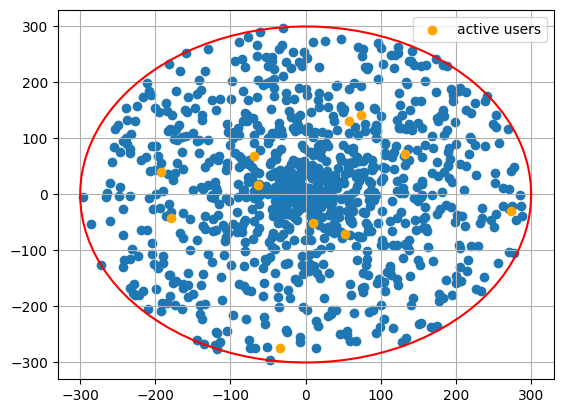

In [29]:
plt.scatter(X[:, 0], X[:, 1])
plt.scatter(Y[:, 0], Y[:, 1], color = 'orange', label='active users')
plt.legend()
draw_circle()
plt.show()

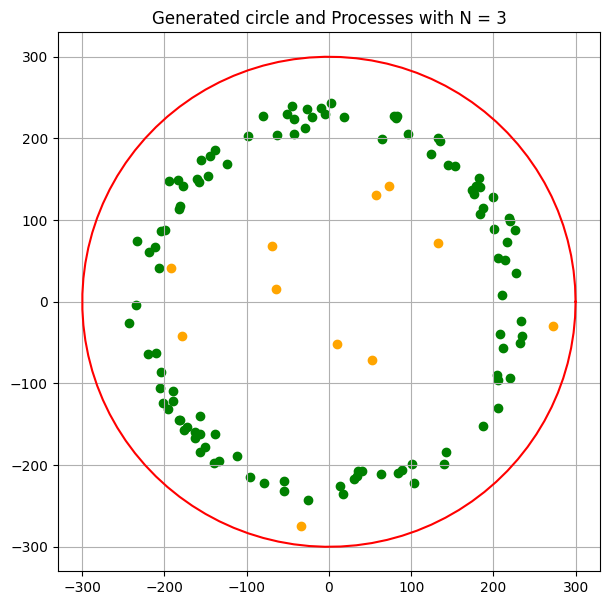

In [30]:
N_3 = []
for i in range(X.shape[0]):
    number_points = N(X[i])
    if number_points == 3:
        N_3.append(X[i])

N_3 = np.array(N_3)

plt.figure(figsize=(7, 7))
plt.title("Generated circle and Processes with N = 3")
plt.scatter(N_3[:, 0], N_3[:, 1], color='green')
plt.scatter(Y[:, 0], Y[:, 1], color = 'orange')
draw_circle()

0.11101775744247316 3.438244924369719e-11


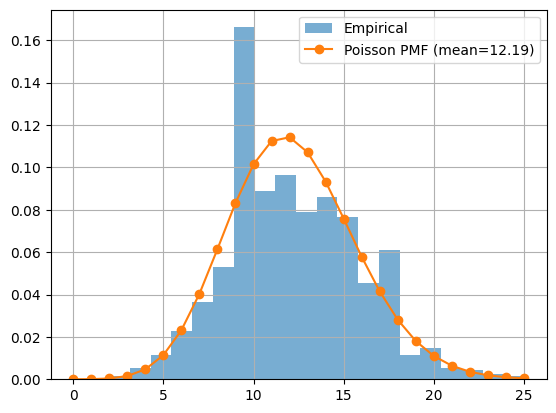

In [31]:
test_rvs = []

while(len(test_rvs) < 1000):   
    temp = simulate_active_users(10000)
    filtered = [p for p in temp if N(p) == 3]
    if filtered != []: 
        test_rvs.append(len(filtered))
    
mean_test = np.mean(test_rvs)
std_test = np.std(test_rvs)

D, pvalue = sp.stats.kstest(test_rvs, 'poisson', args=(mean_test,))
print(D, pvalue)


x = np.arange(0, max(test_rvs)+1)
plt.hist(test_rvs, bins = 20 ,density=True, alpha=0.6, label='Empirical')
plt.plot(sp.stats.poisson(mean_test).pmf(x), 'o-', label='Poisson PMF (mean={:.2f})'.format(mean_test))
plt.legend()
plt.grid()
plt.show()

In [32]:
N_max = Nmax()
print(N_max)

6


[7.51292097 6.18976995 5.24130492 4.71923505 4.37078461 4.11434742]


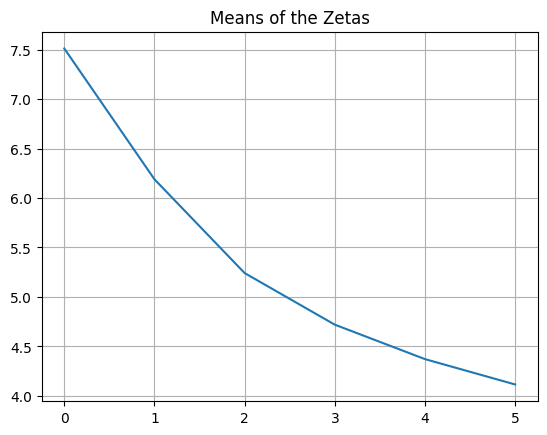

In [33]:
means_zetas = np.zeros(N_max)
for i in range(1, N_max  + 1):
    mean = mean_rv_zeta(i)
    means_zetas[i - 1] = mean

print(means_zetas)

plt.plot(means_zetas)
plt.title("Means of the Zetas")
plt.grid()
plt.show()

In [34]:
K_s = np.zeros(N_max)
for i in range(1, N_max + 1):
    nu = mean_rv_zeta(i)
    K_optim = sp.optimize.fsolve(f, K, args=(nu))
    K_s[i - 1] = K_optim[0] * nu

K_s = np.ceil(K_s)
Kmax = np.max(K_s).astype(int)
# Here we get the Ks necessary to represent a random variable following poisson of parameter nu
print(K_s)

[23. 20. 18. 17. 17. 16.]


In [35]:
distribution_zeta = np.zeros(shape=(N_max, Kmax))
for i in range(1, N_max + 1):
    nu = mean_rv_zeta(i)
    for j in range(Kmax):
        distribution_zeta[i - 1, j] = np.exp(-nu) * (nu ** j) / sp.special.factorial(j)

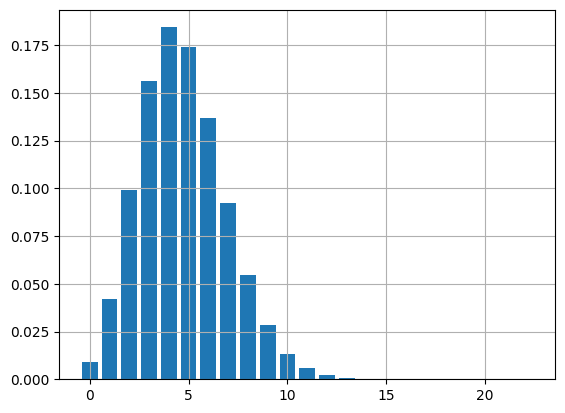

In [36]:
x = np.arange(0, Kmax, 1)
plt.bar(x, distribution_zeta[3])
plt.grid()

In [37]:
distribution_k_zeta = np.zeros((N_max, Kmax * N_max))
for i in range(1, N_max + 1):
    nu = mean_rv_zeta(i)
    for j in range(Kmax):
        distribution_k_zeta[i - 1, i * j] =  np.exp(-nu) * (nu ** j) / sp.special.factorial(j)

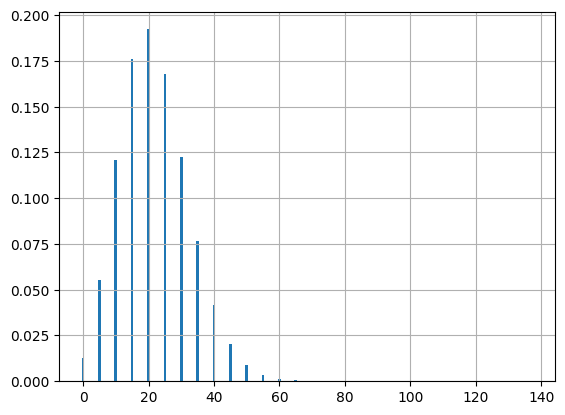

In [38]:
x = np.arange(0, Kmax * N_max, 1)
plt.bar(x, distribution_k_zeta[4])
plt.grid()

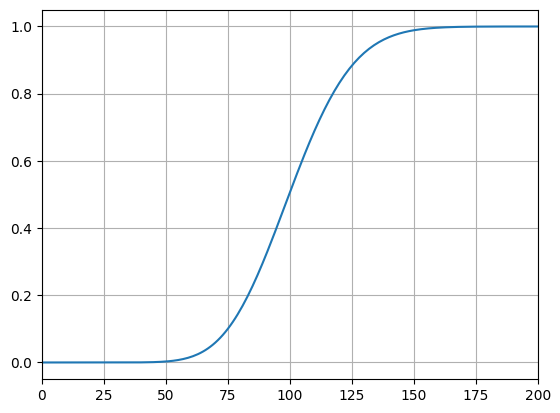

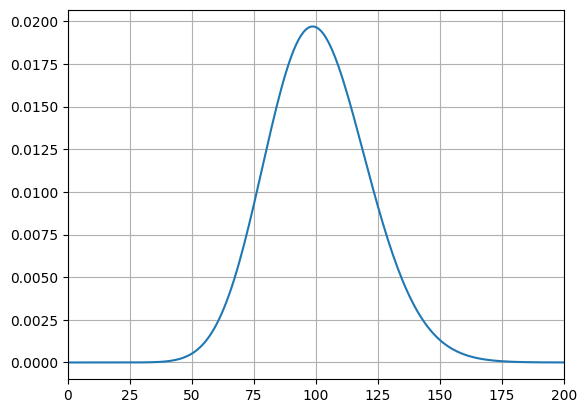

In [39]:
F = distribution_k_zeta[0]

for i in range(1, N_max):
    F = np.convolve(F, distribution_k_zeta[i])


plt.figure()
plt.plot(np.cumsum(F))
plt.grid()
plt.xlim(0, 200)
plt.show()
plt.figure()
plt.plot(F)
plt.grid()
plt.xlim((0, 200))
plt.show()

In [40]:
po = np.cumsum(F)
S = po[po < 0.99]

In [41]:
len(S)

152